Interactive version of the tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pgrigorev/ModMatEcole/HEAD?labpath=tutorials%2FT1_1_python_ecosystem.ipynb)

# Introduction to python

![](https://imgs.xkcd.com/comics/python.png)

The main advantage of using python is that it gives access to a plethora of scientific and data analysis tools. You can look [here](https://learnpython.org/) for interactive examples on basic python syntax. In this tutorial we will use following _packages_:
- [numpy](https://numpy.org/doc/stable/user/whatisnumpy.html) for efficient handling of arrays
- [pandas](https://pandas.pydata.org/) for data manipulation and import/export. 
- [matplotlib](https://matplotlib.org/stable/), [Bokeh](https://bokeh.org/), [Plotly](https://plotly.com/) for (interactive) data visulisation
- [Atomic simulation environment](https://wiki.fysik.dtu.dk/ase/) and [matscipy](https://libatoms.github.io/matscipy/) for working with atomistic systems
- [scikit-learn](https://scikit-learn.org/stable/) for machine learning

Most of these packages have detailed documentation and tutorials, feel free to click the links and explore. 

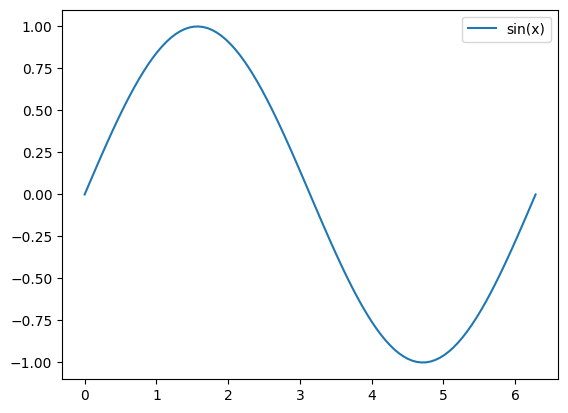

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y, label='sin(x)')
ax.legend()
plt.show()



In [3]:
import plotly.express as px

fig = px.line(x=x, y=y, labels={'x':'x', 'y':'sin(x)'}, width=800, height=500)
fig.show()

In [4]:
import bokeh.plotting as bp
from bokeh.io import output_notebook
output_notebook()

p = bp.figure(width=800, height=500)
p.line(x, y, legend_label='sin(x)')

bp.show(p)

Loading BokehJS ...

# Atomistic simulations

We will use [NGLViewer](http://nglviewer.org/ngl/api/index.html) for interactive visualisation of atomic cells in the notebooks. You can use your mouse to:
- Translation: right click + drag
- Rotation: left click + drag
- Z-axis rotation: Ctrl + right click + drag
- Zoom: scroll wheel
- Center view: left click on the desired atom (or its representation)

You can also represent distances by following this procedure:
- Right click on a single atom. You will see a green sphere wrapping it.
- Double right click on another atom. You will see a dashed line between the two atoms, along with the reported distance in Å.
To remove a distance representation, repeat the sequence on the same atoms.

[Open visualisation tool OVITO](https://www.ovito.org/) can be used to look at atomic configurations. One can use `ase.io.write()` function to save the configuration as `.xyz` file and import it to OVITO. The advantage is that OVITO has a number of analysis tools.

Lets have a look on FCC Ni atomic cell.

In [5]:
from ase.lattice.cubic import FaceCenteredCubic, BodyCenteredCubic
from helper_functions import show_structure


fcc_atoms = FaceCenteredCubic('Fe', latticeconstant=3.6)
print(f"FCC Unit cell contains {len(fcc_atoms)} atoms") 
show_structure(fcc_atoms)


FCC Unit cell contains 4 atoms


NGLWidget()

In [6]:
bcc_atoms = BodyCenteredCubic('Fe', latticeconstant=3.6)
print(f"FCC Unit cell contains {len(bcc_atoms)} atoms") 
show_structure(bcc_atoms)


FCC Unit cell contains 2 atoms


NGLWidget()

we can enlarge the cell by simply repeating it in three directions:

In [7]:
larger_atoms = fcc_atoms * (2, 3, 10)
show_structure(larger_atoms)


NGLWidget()

Now when we have the atomic system we need a model of interatomic interactions. We will use a classical model of pair interaction called [Lennar-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential). The implementation in [ASE calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/others.html#lennard-jones) is based on the following pair interaction function: 
$$ u_{ij} = 4 \epsilon \bigg[ \left(\frac{\sigma}{r_{ij}} \right)^{12} - \left(\frac{\sigma}{r_{ij}} \right)^{6} \bigg] $$
Effectively we will model a Lennard-Jones substance sometimes called "Lennard-Jonesium", however we will take $\sigma$ and $\epsilon$ values inspired by [this paper](https://www.nature.com/articles/s41524-020-00478-1) to have lattice constants and cohesibe energy close to pure Fe.

In [8]:
from ase.calculators.lj import LennardJones
from ase.units import kcal, mol
LJ_calc = LennardJones(epsilon=12.0 * (kcal / mol), sigma=2.31)

[ASE](https://wiki.fysik.dtu.dk/ase/) calculator class is an abstract class that returns energies and forces when given an atomic configuration in a form of atoms object. ASE has an interface to a dozens of codes based on different physical models: Density Functional Thoery, Tight Binding, classical and machine learning interatomic potentials.

In [9]:
fcc_atoms = FaceCenteredCubic('Fe', latticeconstant=3.6)
fcc_atoms.calc = LJ_calc
fcc_atoms.get_potential_energy()

-16.486695356408326

In [10]:
fcc_atoms.get_forces()

array([[-6.76542156e-17, -3.72965547e-17,  1.12757026e-17],
       [-9.54097912e-17, -1.74773390e-16, -4.42354486e-17],
       [-1.34441069e-16, -1.95156391e-17, -1.49619900e-16],
       [ 6.54858112e-17, -2.60642202e-16, -1.28369537e-16]])

Lets check that our LJ parametrisation ($\sigma$ and $\epsilon$ values) indeed gives reasonable lattice constant for FCC lattice. For this we will see how potential energy varies when we change the size of the unit cell

In [11]:
lattice_constants = np.linspace(3.45, 3.75, 11)
fcc_energies = []
fcc_boxes = [FaceCenteredCubic('Fe', latticeconstant=a) for a in lattice_constants]


In [12]:
show_structure(fcc_boxes[0])

NGLWidget()

In [13]:
show_structure(fcc_boxes[-1])

NGLWidget()

In [14]:
fcc_energies = []
for fcc_atoms in fcc_boxes:
    fcc_atoms.calc = LJ_calc
    fcc_energies.append(fcc_atoms.get_potential_energy() / len(fcc_atoms))

Text(0, 0.5, 'Energy per atom [eV]')

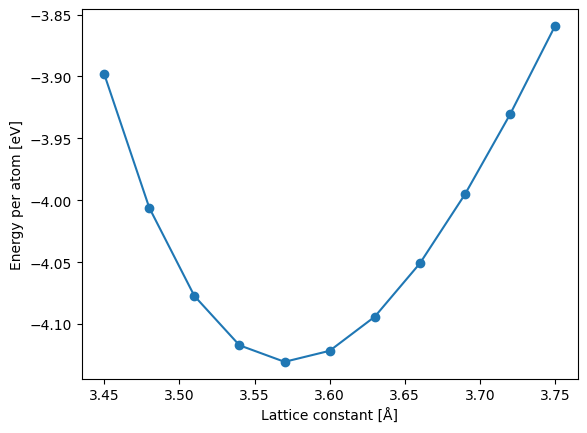

In [15]:
fig, ax = plt.subplots()
ax.plot(lattice_constants, fcc_energies, 'o-')
ax.set_xlabel('Lattice constant [Å]')
ax.set_ylabel('Energy per atom [eV]')

Indded there is a minimum around ~3.56 Angstom with a reasonable value of cogesive energy. Check if this is true!

Lest wrap this calculation in an abstract function and check also Bulk Centered Lattice.

In [16]:
def equation_of_state(lattice, lattice_constants, calculator, symbol='Fe'):
    energies = []
    for a in lattice_constants:
        atoms = lattice(symbol, latticeconstant=a)
        atoms.calc = calculator
        energies.append(atoms.get_potential_energy() / len(atoms))
    return energies

We will have to change the lattice constants for BCC to have the roughly the same volume per atom to see the stability of the system.

In [17]:
bcc_lattice_constants = lattice_constants / 2 ** (1 / 3)
bcc_energies = equation_of_state(BodyCenteredCubic, bcc_lattice_constants, LJ_calc)

Now lets plot the results using matplotlib.

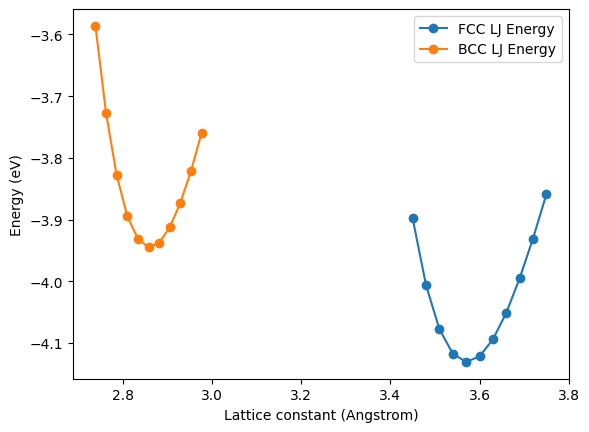

In [18]:
fig, ax = plt.subplots()

ax.plot(lattice_constants, fcc_energies, "-o", label='FCC LJ Energy')
ax.plot(bcc_lattice_constants, bcc_energies, "-o", label='BCC LJ Energy')
ax.set_xlabel('Lattice constant (Angstrom)')
ax.set_ylabel('Energy (eV)')
ax.legend()

As we can see for BCC there is a minimum of around 2.81 Ansgtrom and that for our LJ substance FCC lattice is predicted to be more stable than BCC at O K. Is it a good approximation for pure Fe?

Lets see what more advanced methods can give. We can take Embedded Atom Method (EAM) as an example. [NIST interatomic potentials repository](https://www.ctcms.nist.gov/potentials/) is a good place to start to look for the potentials. What we are looking for a `.eam.fs` files for pure Fe. Pick a potentials anf upload the file to a location where you can access it from the notebook. I will take the potential from [Proville, L., Rodney, D. & Marinica, MC. Quantum effect on thermally activated glide of dislocations. Nature Mater 11, 845–849 (2012).](https://www.nature.com/articles/nmat3401)

In [19]:
from matscipy.calculators.eam import EAM
eam_calc = EAM("../potentials/MCM2011_eam.fs")

Now we can repeat the calculation using our `equation of state` function:

In [20]:
eam_bcc_energies = equation_of_state(BodyCenteredCubic, bcc_lattice_constants, eam_calc)
eam_fcc_energies = equation_of_state(FaceCenteredCubic, lattice_constants, eam_calc)

Lets use pandas to put the data together for plotting.

In [21]:
import pandas as pd
dataframe = pd.DataFrame({'Lattice constant': lattice_constants, 'FCC LJ Energy': fcc_energies, 'FCC EAM Energy': eam_fcc_energies,
                          'BCC lattice constants': bcc_lattice_constants, 'BCC LJ Energy': bcc_energies, 'BCC EAM Energy': eam_bcc_energies})

dataframe

,Lattice constant,FCC LJ Energy,FCC EAM Energy,BCC lattice constants,BCC LJ Energy,BCC EAM Energy
0,3.45,-3.898016,-3.874730,2.738267,-3.586110,-4.081382
1,3.48,-4.006116,-3.895835,2.762078,-3.727495,-4.103618
2,3.51,-4.077367,-3.921676,2.785889,-3.828172,-4.116723
3,3.54,-4.117224,-3.948010,2.809700,-3.894240,-4.122270
4,3.57,-4.130585,-3.971036,2.833511,-3.931277,-4.119945
5,3.60,-4.121674,-3.988116,2.857322,-3.944863,-4.109261
6,3.63,-4.094132,-3.997777,2.881133,-3.937487,-4.089723
7,3.66,-4.051098,-4.000415,2.904944,-3.912543,-4.060936
8,3.69,-3.995275,-3.996617,2.928755,-3.872961,-4.024015
9,3.72,-3.930707,-3.986607,2.952566,-3.821269,-3.981392


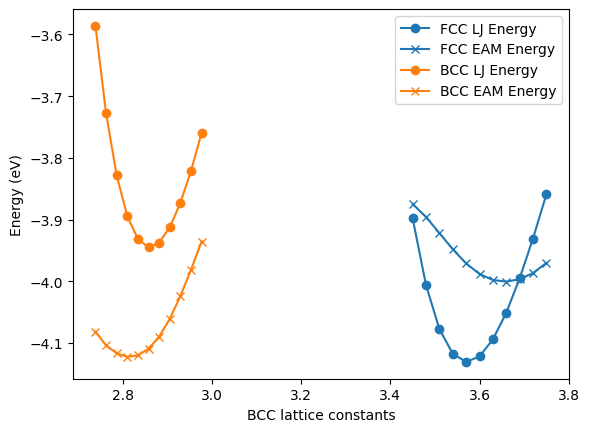

In [22]:
ax = dataframe.plot(x='Lattice constant', y=['FCC LJ Energy', 'FCC EAM Energy'], style=['C0o-', 'C0x-'])
dataframe.plot(x='BCC lattice constants', y=['BCC LJ Energy', 'BCC EAM Energy'], style=['C1o-', 'C1x-'], ax=ax)
ax.set_ylabel('Energy (eV)')

# here is example of how to save the dataframe to a csv file
dataframe.to_csv('lattice_energies.csv', index=False)


In [23]:
dataframe.min()

Lattice constant         3.450000
FCC LJ Energy           -4.130585
FCC EAM Energy          -4.000415
BCC lattice constants    2.738267
BCC LJ Energy           -3.944863
BCC EAM Energy          -4.122270
dtype: float64

In order to get the predicted lattice constants we can use `idxmin()` function to get the index of minimum energy value and `iloc[]` to get the corresponding value of the box size.

In [24]:
dataframe['Lattice constant'].iloc[dataframe['FCC EAM Energy'].idxmin()]

3.66

In [25]:
dataframe['Lattice constant'].iloc[dataframe['FCC LJ Energy'].idxmin()]

3.5700000000000003

We can see that EAM potential potential predicts BCC to be more stable, which is a better description of pure Fe. If you want to explore further try to check other potentials form NIST database and/or other lattices such as HCP (do not forget to change lattice constants accordingly).

Actually what we did is called Equation of State and can be used to obtain bulk modulus of the material. It is [implemented in ASE](https://wiki.fysik.dtu.dk/ase/ase/eos.html) and can be used as:

Lattice constant: 2.8114 Å


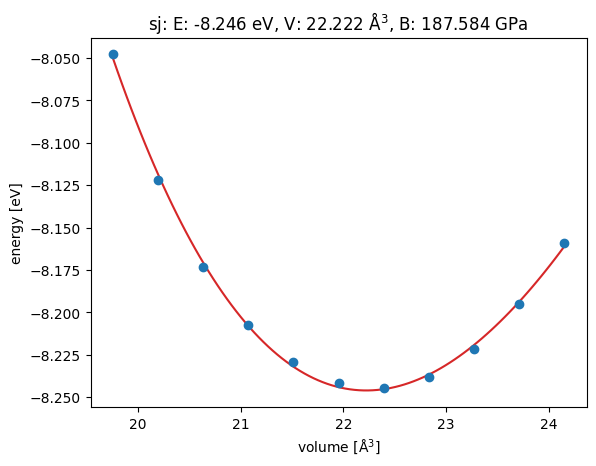

In [26]:
from ase.eos import calculate_eos
atoms = BodyCenteredCubic('Fe', latticeconstant=2.8)
atoms.calc = eam_calc
eos = calculate_eos(atoms, npoints=11, eps=0.1)
eos.plot()

print(f'Lattice constant: {eos.v0 ** (1/3):.4f} Å')

Other elastic constants can be calculated with matscipy. Check if these values are the same as one reported on [NIST page](https://www.ctcms.nist.gov/potentials/entry/2012--Proville-L-Rodney-D-Marinica-M-C--Fe/2012--Proville-L--Fe--LAMMPS--ipr1.html) - it is a good practice to ensure your simulation set up is working correctly.

In [27]:
from matscipy.dislocation import get_elastic_constants
get_elastic_constants(symbol='Fe', calculator=eam_calc)

PreconLBFGS:   0  10:11:13       -8.199984       2.7576
PreconLBFGS:   1  10:11:13       -8.243199       0.4961
PreconLBFGS:   2  10:11:13       -8.244889       0.0435
PreconLBFGS:   3  10:11:13       -8.244901       0.0008
PreconLBFGS:   4  10:11:13       -8.244901       0.0003
PreconLBFGS:   5  10:11:13       -8.244901       0.0000
Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-4.43862394e+00, -2.29615086e+00, -1.07951172e-05,  2.59183367e+00,
        5.50043128e+00]) GPa
Cij (gradient) / GPa    :     247.6609496822697
Error in Cij / GPa      :     8.97294534161905
Correlation coefficient :     0.9980367940808776
Setting C11 (1) to 1.545778 +/- 0.056005


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-2.88043223e+00, -1.44494641e+00, -1.07951326e-05,  1.45512735e+00,
        2.92025410e+00]) GPa
Cij (gradient) / GPa    :     145.0144643132757
Error in Cij / GPa      :     0.3390699335460686
Correlation coefficient :     0.

/home/petr/miniconda3/envs/modmat/lib/python3.12/site-packages/matscipy/dislocation.py:484: FutureWarning:

Import StrainFilter from ase.filters



(2.8147786278637548, 247.6609496822697, 145.01446431357292, 115.97138880483999)

## Vacancy and interstitial formation energies

In order to calculate defect formation we will use the following formula:
$$ E_{form}^{defect} = E_{total}^{defect} - \frac{N_{at}^{defect}}{N_{at}^{bulk}} E_{total}^{bulk} $$ 
This means we first will need to know energy of the reference configuration. Actually we will need energy per atom for a perfect configuration $\frac{E_{total}^{bulk}}{N_{at}^{bulk}} $ i.e. _cohesive energy_

In [28]:
bulk_unit_cell = BodyCenteredCubic('Fe', latticeconstant=2.8147)
bulk_unit_cell.calc = eam_calc
ecoh = bulk_unit_cell.get_potential_energy() / len(bulk_unit_cell)
print(f'Cohesive energy: {ecoh:.4f} eV')

Cohesive energy: -4.1225 eV


To avoid cell size effects we will need to use larger cell.

In [29]:
bulk_material = bulk_unit_cell * (5, 5, 5)
show_structure(bulk_material)

NGLWidget()

In [30]:
bulk_material.calc = eam_calc
print(f'Total potential energy: {bulk_material.get_potential_energy()} eV')
print(f'From cohesive energy: {len(bulk_material) * ecoh} eV')
# we can use np.testing.assert_almost_equal to compare two floating point numbers
np.testing.assert_almost_equal(bulk_material.get_potential_energy(), len(bulk_material) * ecoh)

Total potential energy: -1030.6126646309197 eV
From cohesive energy: -1030.6126646309197 eV


Lets make sure that forces are zero as well.

In [31]:
np.max(np.abs(bulk_material.get_forces()))

5.464378949326942e-15

Lets create a vacancy by deleting one atom:

In [32]:
vacancy = bulk_material.copy()
del vacancy[0]
show_structure(vacancy)

NGLWidget()

Check the maximum force again:

In [33]:
vacancy.calc = eam_calc
np.max(np.abs(vacancy.get_forces()))

0.5248768061393313

We will have to relax the structure for correct formation energy.

In [34]:
from ase.optimize.precon import PreconLBFGS

opt = PreconLBFGS(vacancy)
opt.run(fmax=0.01)

PreconLBFGS:   0  10:11:30    -1024.238539       0.5249
PreconLBFGS:   1  10:11:33    -1024.360896       0.3172
PreconLBFGS:   2  10:11:33    -1024.451703       0.1762
PreconLBFGS:   3  10:11:34    -1024.473871       0.1238
PreconLBFGS:   4  10:11:35    -1024.502746       0.0645
PreconLBFGS:   5  10:11:36    -1024.509478       0.0529
PreconLBFGS:   6  10:11:36    -1024.516675       0.0230
PreconLBFGS:   7  10:11:37    -1024.519660       0.0249
PreconLBFGS:   8  10:11:38    -1024.521529       0.0222
PreconLBFGS:   9  10:11:39    -1024.522788       0.0111
PreconLBFGS:  10  10:11:39    -1024.523241       0.0067


True

In [35]:
E_formation = vacancy.get_potential_energy() - len(vacancy) * ecoh
print(f'Vacancy formation energy: {E_formation:.3f} eV')

Vacancy formation energy: 1.967 eV


Again, check this value from what is reported in [NIST](https://www.ctcms.nist.gov/potentials/entry/2012--Proville-L-Rodney-D-Marinica-M-C--Fe/2012--Proville-L--Fe--LAMMPS--ipr1.html). 

We can estimate the equilibrium vacancy concentration in Fe with simple formula: $ C_V = \exp(-E_f/k_BT)$ (here we ignore entropy effects)


In [85]:
from ase.units import kB
T = np.linspace(300, 1900, 100)

fig = px.line(x=T, y=np.exp(-(E_formation)/ (kB * T)), 
              labels={'x':'Temperature (K)', 'y':'Vacancy concentration'}, width=800, height=500)
fig.show()


In [86]:
#log scale can be used for y-axis
fig = px.line(x=T, y=np.exp(-(E_formation)/ (kB * T)), 
              labels={'x':'Temperature (K)', 'y':'Vacancy concentration'}, log_y=True, width=800, height=500)
fig.show()

Lets estmate formation energy for interstitials.

In [56]:
from ase.atom import Atom
interstitial = bulk_material.copy()
# we are looking for <110> dumbbell interstitial
interstitial.extend(Atom('Fe', np.array([0.4, 0.4, 0.0]) * 2.8147))
show_structure(interstitial)

NGLWidget()

In [57]:
interstitial.calc = eam_calc
opt = PreconLBFGS(interstitial)
opt.run(fmax=0.01)


PreconLBFGS:   0  11:10:35     -980.864505      82.0267
PreconLBFGS:   1  11:10:38     -988.327398      71.4269
PreconLBFGS:   2  11:10:39     -991.504827      70.9005
PreconLBFGS:   3  11:10:40     -996.873861      62.4072
PreconLBFGS:   4  11:10:40    -1000.214364      57.9616
PreconLBFGS:   5  11:10:41    -1003.550512      53.1348
PreconLBFGS:   6  11:10:42    -1007.009828      47.9904
PreconLBFGS:   7  11:10:43    -1010.058417      43.5346
PreconLBFGS:   8  11:10:44    -1012.725802      41.9419
PreconLBFGS:   9  11:10:45    -1015.253664      35.8140
PreconLBFGS:  10  11:10:45    -1017.653176      31.5468
PreconLBFGS:  11  11:10:46    -1019.819491      27.9073
PreconLBFGS:  12  11:10:47    -1021.764605      24.5227
PreconLBFGS:  13  11:10:48    -1023.461998      21.5086
PreconLBFGS:  14  11:10:49    -1024.997859      18.4085
PreconLBFGS:  15  11:10:50    -1026.401928      15.4750
PreconLBFGS:  16  11:10:50    -1027.492272      13.1768
PreconLBFGS:  17  11:10:51    -1028.513428      

Passed direction which is not downhill. Aborting...: 1.527301e-06


PreconLBFGS:  44  11:11:16    -1031.363789       0.2565


/home/petr/miniconda3/envs/modmat/lib/python3.12/site-packages/ase/optimize/precon/lbfgs.py:340: UserWarning:

Armijo linesearch failed, resetting Hessian and trying again



PreconLBFGS:  45  11:11:17    -1031.363793       0.2564
PreconLBFGS:  46  11:11:18    -1031.363802       0.2563
PreconLBFGS:  47  11:11:19    -1031.363820       0.2561
PreconLBFGS:  48  11:11:20    -1031.363855       0.2559
PreconLBFGS:  49  11:11:21    -1031.363926       0.2555
PreconLBFGS:  50  11:11:22    -1031.364067       0.2547
PreconLBFGS:  51  11:11:23    -1031.364348       0.2536
PreconLBFGS:  52  11:11:24    -1031.364910       0.2506
PreconLBFGS:  53  11:11:25    -1031.366027       0.2469
PreconLBFGS:  54  11:11:26    -1031.368242       0.2370
PreconLBFGS:  55  11:11:27    -1031.372597       0.2255
PreconLBFGS:  56  11:11:28    -1031.380993       0.1902
PreconLBFGS:  57  11:11:29    -1031.396199       0.1491
PreconLBFGS:  58  11:11:30    -1031.412122       0.1026
PreconLBFGS:  59  11:11:31    -1031.417726       0.2184
PreconLBFGS:  60  11:11:32    -1031.421161       0.1261
PreconLBFGS:  61  11:11:33    -1031.423115       0.1157
PreconLBFGS:  62  11:11:34    -1031.427742      

True

In [58]:
show_structure(interstitial)

NGLWidget()

In [59]:
SIA_form_energy = interstitial.get_potential_energy() - len(interstitial) * ecoh
print(f'Self-interstitial formation energy: {SIA_form_energy:.3f} eV')

Self-interstitial formation energy: 3.303 eV


Lets wrap these calculations in functions.

In [72]:
def vacancy_formation_energy(calculator, symbol="Fe", size=(5, 5, 5)):

    alat, _, _, _ = get_elastic_constants(symbol=symbol, calculator=calculator)
    bulk_unit_cell = BodyCenteredCubic(symbol, latticeconstant=alat)
    bulk_unit_cell.calc = calculator
    ecoh = bulk_unit_cell.get_potential_energy() / len(bulk_unit_cell)

    bulk_material = bulk_unit_cell * size
    vacancy = bulk_material.copy()
    del vacancy[0]
    vacancy.calc = calculator
    opt = PreconLBFGS(vacancy)
    opt.run(fmax=0.01)
    E_formation = vacancy.get_potential_energy() - len(vacancy) * ecoh

    return E_formation, vacancy

def SIA_formation_energy(calculator, symbol="Fe", size=(5, 5, 5)):
    alat, _, _, _ = get_elastic_constants(symbol=symbol, calculator=calculator)
    bulk_unit_cell = BodyCenteredCubic(symbol, latticeconstant=alat)
    bulk_unit_cell.calc = calculator
    ecoh = bulk_unit_cell.get_potential_energy() / len(bulk_unit_cell)

    bulk_material = bulk_unit_cell * size
    interstitial = bulk_material.copy()
    interstitial.extend(Atom(symbol, np.array([0.4, 0.4, 0.0]) * alat))
    interstitial.calc = calculator
    opt = PreconLBFGS(interstitial)
    opt.run(fmax=0.01)
    SIA_form_energy = interstitial.get_potential_energy() - len(interstitial) * ecoh

    return SIA_form_energy, interstitial

In [73]:
eam_vac_formen, _ = vacancy_formation_energy(eam_calc)
eam_sia_formen, _ = SIA_formation_energy(eam_calc)

PreconLBFGS:   0  11:33:30       -8.199984       2.7576
PreconLBFGS:   1  11:33:30       -8.243199       0.4961
PreconLBFGS:   2  11:33:30       -8.244889       0.0435
PreconLBFGS:   3  11:33:30       -8.244901       0.0008
PreconLBFGS:   4  11:33:30       -8.244901       0.0003
PreconLBFGS:   5  11:33:30       -8.244901       0.0000


/home/petr/miniconda3/envs/modmat/lib/python3.12/site-packages/matscipy/dislocation.py:484: FutureWarning:

Import StrainFilter from ase.filters



Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-4.43862394e+00, -2.29615086e+00, -1.07951172e-05,  2.59183367e+00,
        5.50043128e+00]) GPa
Cij (gradient) / GPa    :     247.6609496822697
Error in Cij / GPa      :     8.97294534161905
Correlation coefficient :     0.9980367940808776
Setting C11 (1) to 1.545778 +/- 0.056005


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-2.88043223e+00, -1.44494641e+00, -1.07951326e-05,  1.45512735e+00,
        2.92025410e+00]) GPa
Cij (gradient) / GPa    :     145.0144643132757
Error in Cij / GPa      :     0.3390699335460686
Correlation coefficient :     0.9999917994716584
Setting C21 (7) to 0.905109 +/- 0.002116


Fitting C_31
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-2.88043224e+00, -1.44494641e+00, -1.07955232e-05,  1.45512735e+00,
        2.92025410e+00]) GPa
Cij (gradient) / GPa    :     145.01446431387012
Error in Cij / GPa      :     0.33906993352450565
Cor

Passed direction which is not downhill. Aborting...: 2.131570e-06


PreconLBFGS:  44  11:34:25    -1031.365091       0.2564


/home/petr/miniconda3/envs/modmat/lib/python3.12/site-packages/ase/optimize/precon/lbfgs.py:340: UserWarning:

Armijo linesearch failed, resetting Hessian and trying again



PreconLBFGS:  45  11:34:26    -1031.365094       0.2563
PreconLBFGS:  46  11:34:27    -1031.365102       0.2563
PreconLBFGS:  47  11:34:28    -1031.365118       0.2561
PreconLBFGS:  48  11:34:29    -1031.365149       0.2559
PreconLBFGS:  49  11:34:30    -1031.365211       0.2556
PreconLBFGS:  50  11:34:31    -1031.365336       0.2548
PreconLBFGS:  51  11:34:32    -1031.365585       0.2539
PreconLBFGS:  52  11:34:33    -1031.366081       0.2513
PreconLBFGS:  53  11:34:33    -1031.367070       0.2480
PreconLBFGS:  54  11:34:35    -1031.369032       0.2393
PreconLBFGS:  55  11:34:36    -1031.372898       0.2290
PreconLBFGS:  56  11:34:37    -1031.380393       0.1982
PreconLBFGS:  57  11:34:37    -1031.394236       0.1638
PreconLBFGS:  58  11:34:38    -1031.411634       0.1089
PreconLBFGS:  59  11:34:39    -1031.418004       0.2436
PreconLBFGS:  60  11:34:40    -1031.422545       0.1323
PreconLBFGS:  61  11:34:41    -1031.424308       0.1088
PreconLBFGS:  62  11:34:42    -1031.427229      

In [74]:
LJ_vac_formen, _ = vacancy_formation_energy(LJ_calc)
LJ_sia_formen, sia_LJ = SIA_formation_energy(LJ_calc)

PreconLBFGS:   0  11:34:50       -7.886634       1.1326
PreconLBFGS:   1  11:34:50       -7.889989       0.1204
PreconLBFGS:   2  11:34:50       -7.890026       0.0040
PreconLBFGS:   3  11:34:50       -7.890026       0.0000
Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-9.12641765e+00, -4.31466143e+00,  5.32319940e-05,  3.60646774e+00,
        6.60518245e+00]) GPa
Cij (gradient) / GPa    :     393.8432935692774
Error in Cij / GPa      :     21.170212730634795
Correlation coefficient :     0.9956939153524681
Setting C11 (1) to 2.458177 +/- 0.132134


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.07931716e+01, -5.09194238e+00,  5.32319941e-05,  4.48254623e+00,
        8.42895754e+00]) GPa
Cij (gradient) / GPa    :     480.1874698520966
Error in Cij / GPa      :     20.104417767949375
Correlation coefficient :     0.9973809496783743
Setting C21 (7) to 2.997094 +/- 0.125482


Fitting C_31
Strain array([-0.02, -0.01,  0.  ,  0

In [75]:
LJ_sia_formen

0.8437423460117088

In [76]:
show_structure(sia_LJ)

NGLWidget()

<Axes: ylabel='Formation energy (eV)'>

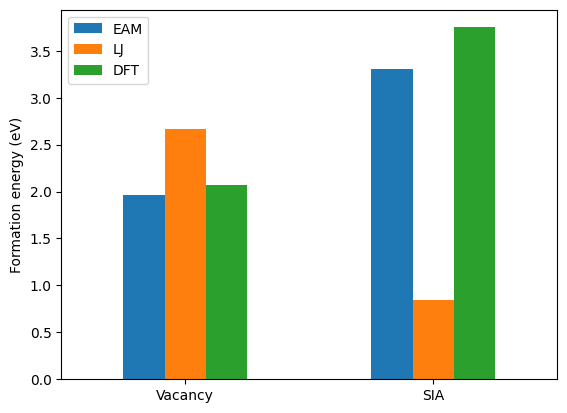

In [77]:
dataframe = pd.DataFrame({'EAM': [eam_vac_formen, eam_sia_formen], 
                          'LJ': [LJ_vac_formen, LJ_sia_formen],
                          "DFT": [2.07, 3.75]}, # refs: https://doi.org/10.1103/PhysRevB.65.024103 https://doi.org/10.1016/j.nimb.2004.10.028
                           index=['Vacancy', 'SIA'])

dataframe.plot(kind='bar', rot=0, ylabel='Formation energy (eV)')

Lets see the cell size effects:

In [78]:
vacancy_formation_energies = []
for s in range(2, 11):
    print(f'Calculating vacancy formation energy for size {s}x{s}x{s}'.center(80, '-'))
    eam_vac_formen, _ = vacancy_formation_energy(eam_calc, size=(s, s, s))
    vacancy_formation_energies.append(eam_vac_formen)

--------------Calculating vacancy formation energy for size 2x2x2---------------
PreconLBFGS:   0  11:35:56       -8.199984       2.7576


PreconLBFGS:   1  11:35:56       -8.243199       0.4961
PreconLBFGS:   2  11:35:56       -8.244889       0.0435
PreconLBFGS:   3  11:35:56       -8.244901       0.0008
PreconLBFGS:   4  11:35:56       -8.244901       0.0003
PreconLBFGS:   5  11:35:56       -8.244901       0.0000
Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-4.43862394e+00, -2.29615086e+00, -1.07951172e-05,  2.59183367e+00,
        5.50043128e+00]) GPa
Cij (gradient) / GPa    :     247.6609496822697
Error in Cij / GPa      :     8.97294534161905
Correlation coefficient :     0.9980367940808776
Setting C11 (1) to 1.545778 +/- 0.056005


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-2.88043223e+00, -1.44494641e+00, -1.07951326e-05,  1.45512735e+00,
        2.92025410e+00]) GPa
Cij (gradient) / GPa    :     145.0144643132757
Error in Cij / GPa      :     0.3390699335460686
Correlation coefficient :     0.9999917994716584
Setting C21 (7) to 0.905109 +/- 0.00211

/home/petr/miniconda3/envs/modmat/lib/python3.12/site-packages/matscipy/dislocation.py:484: FutureWarning:

Import StrainFilter from ase.filters

/home/petr/miniconda3/envs/modmat/lib/python3.12/site-packages/ase/optimize/precon/lbfgs.py:133: UserWarning:

The system is likely too small to benefit from the standard preconditioner, hence it is disabled. To re-enable preconditioning, call `PreconLBFGS` by explicitly providing the kwarg `precon`



PreconLBFGS:   0  11:35:57      -59.578567       0.0431
PreconLBFGS:   1  11:35:57      -59.581246       0.0007
--------------Calculating vacancy formation energy for size 3x3x3---------------
PreconLBFGS:   0  11:35:57       -8.199984       2.7576
PreconLBFGS:   1  11:35:57       -8.243199       0.4961
PreconLBFGS:   2  11:35:57       -8.244889       0.0435
PreconLBFGS:   3  11:35:57       -8.244901       0.0008
PreconLBFGS:   4  11:35:57       -8.244901       0.0003
PreconLBFGS:   5  11:35:57       -8.244901       0.0000
Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-4.43862394e+00, -2.29615086e+00, -1.07951172e-05,  2.59183367e+00,
        5.50043128e+00]) GPa
Cij (gradient) / GPa    :     247.6609496822697
Error in Cij / GPa      :     8.97294534161905
Correlation coefficient :     0.9980367940808776
Setting C11 (1) to 1.545778 +/- 0.056005


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-2.88043223e+00, -1.44494641e+00,

Text(0, 0.5, 'Vacancy formation energy (eV)')

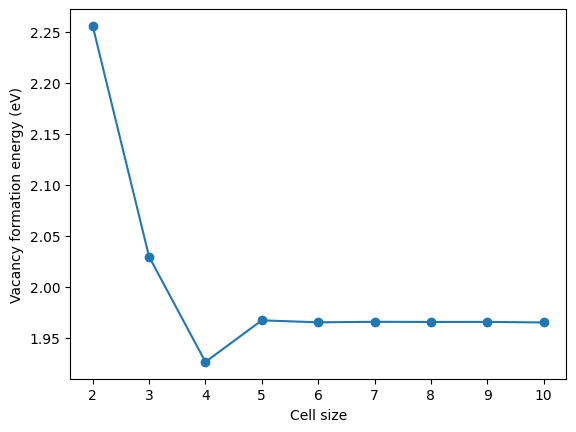

In [79]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), vacancy_formation_energies, 'o-')
ax.set_xlabel('Cell size')
ax.set_ylabel('Vacancy formation energy (eV)')


Seems like 5x5x5 will be ok.

What we did here is a parametric study with an application of a workflow. Workflow management systems can be very useful in tis kind of scenarios. Here are a few examples:
[snakemake](https://snakemake.github.io/), [fireworks](https://materialsproject.github.io/fireworks/workflow_tutorial.html), [pyiron](https://pyiron.org/), [AiiDA](https://www.aiida.net/), [automate](https://atomate.org/), [wfl](https://libatoms.github.io/workflow/), [jobflow](https://materialsproject.github.io/jobflow/). 

## Vacancy migration barrier

Together with formation energy, migration energy is an important parameter that controls diffusion and can be calculated from atomistic simulations using Nudge Elastic Band method.

In [80]:
from ase.mep.neb import NEB, NEBOptimizer
fmax_relax = 0.01
fmax_neb = 0.05
size = (5, 5, 5)
n_knots = 11
calc = eam_calc

bulk_unit_cell = BodyCenteredCubic('Fe', latticeconstant=2.8147)
bulk_material = bulk_unit_cell * size
ini_cell = bulk_material.copy()
fin_cell = bulk_material.copy()

vac_position = ini_cell.get_positions()[1]
del ini_cell[[1]]
del fin_cell[[1]]

fin_cell.positions[0] = vac_position

# relaxation

for cell in [ini_cell, fin_cell]:
    cell.calc = calc
    opt = PreconLBFGS(cell)
    opt.run(fmax=fmax_relax)


PreconLBFGS:   0  11:40:29    -1024.238539       0.5249
PreconLBFGS:   1  11:40:32    -1024.360891       0.3172
PreconLBFGS:   2  11:40:33    -1024.451697       0.1762
PreconLBFGS:   3  11:40:34    -1024.473865       0.1238
PreconLBFGS:   4  11:40:35    -1024.502752       0.0641
PreconLBFGS:   5  11:40:36    -1024.509481       0.0529
PreconLBFGS:   6  11:40:37    -1024.516674       0.0230
PreconLBFGS:   7  11:40:38    -1024.519660       0.0249
PreconLBFGS:   8  11:40:39    -1024.521529       0.0222
PreconLBFGS:   9  11:40:40    -1024.522788       0.0111
PreconLBFGS:  10  11:40:41    -1024.523241       0.0067
PreconLBFGS:   0  11:40:42    -1024.238539       0.5249
PreconLBFGS:   1  11:40:45    -1024.360896       0.3172
PreconLBFGS:   2  11:40:45    -1024.451703       0.1762
PreconLBFGS:   3  11:40:46    -1024.473871       0.1238
PreconLBFGS:   4  11:40:47    -1024.502746       0.0645
PreconLBFGS:   5  11:40:48    -1024.509478       0.0529
PreconLBFGS:   6  11:40:49    -1024.516675      

Lets have a look on initial and final configuration:

In [81]:
from ase.visualize.ngl import view_ngl
view_ngl([ini_cell, fin_cell])

In [82]:

images = [ini_cell] + [ini_cell.copy() for i in range(n_knots)] + [fin_cell]

for image in images:
    image.calc = calc

nb = NEB(images, allow_shared_calculator=True)
nb.interpolate()

opt = NEBOptimizer(nb)
print(f"Starting NEB".center(80, '-'))
opt.run(fmax_neb, steps=150)


----------------------------------Starting NEB----------------------------------
                   Step     Time         fmax
NEBOptimizer[ode]:    0 11:41:17       0.1616
NEBOptimizer[ode]:    1 11:41:26       0.0896
NEBOptimizer[ode]:    2 11:41:35       0.0920
NEBOptimizer[ode]:    3 11:41:44       0.1582
NEBOptimizer[ode]:    4 11:41:53       0.0940
NEBOptimizer[ode]:    5 11:42:02       0.0308


True

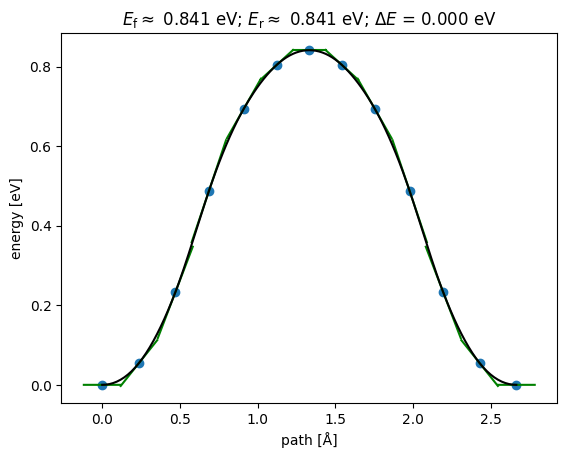

In [83]:
from ase.mep.neb import NEBTools
NEBTools(nb.images).plot_band();

In [84]:
view_ngl(nb.images)

Vacancy formation and migration are important for self diffusion and can be determined experimentally by looking at migration of radio-isotopes. For $\alpha$-Fe the activation energy is reported to be 2.8 eV which is in a good agreement with $E^{vac}_{formation} + E^{vac}_{migration}$ = 1.96 + 0.84. See chapter 19.8 of [A. Cotrell An Introduction to Metallurgy](https://doi.org/10.1201/9780429293917) for more details.

In recent years machine learning based interatomic potentials made a huge progress and allow to achieve unprecedented accuracy. However, they are significantly more computationally expensive than classical potentials which does not allow us to do interactive calculations here. However, same mindset on testing the models is applicable to ML based models. Many of them provide ASE compatible calculators, so the same wokrflow can be employed. A recent [neural network based universal model called MACE-MP-0](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) is a good example. In chapter "A.13 Point and extended defects in BCC metals" of [this preprint](https://arxiv.org/abs/2401.00096v2) how it was tested for phase stability and point defect properties.


For other extended defects you can have a look on [matscipy documentation](https://libatoms.github.io/matscipy/) and examples for [gamma surfaces and stacking faults](https://libatoms.github.io/matscipy/applications/gamma_surfaces.html), [dislocations](https://libatoms.github.io/matscipy/applications/cylinder_configurations.html) and [cracks](https://libatoms.github.io/matscipy/applications/cylinder_configurations.html). [Atomsk](https://atomsk.univ-lille.fr/) can be also used to create atomistic systems with grain boundaries and polycristals.